In [ ]:
!pip install -q tensorflow #framework open-source buatan Google untuk machine learning dan deep learning. untuk membangun dan melatih model neural network.
!pip install seaborn #empermudah pembuatan grafik statistik seperti heatmap, histogram
!pip install gradio #untuk membuat demo aplikasi AI seperti klasifikasi gambar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ======== Library untuk manipulasi data dan komputasi numerik ========
import pandas as pd           # Untuk memproses data tabular seperti CSV
import numpy as np            # Untuk operasi numerik dan array

# ======== Library untuk Deep Learning (TensorFlow) ========
import tensorflow as tf       # Framework deep learning dari Google (CNN, LSTM, dll)

# ======== Library visualisasi data ========
import matplotlib.pyplot as plt  # Untuk membuat plot seperti grafik garis, histogram, dll
import seaborn as sns            # Untuk membuat visualisasi statistik yang menarik

# ======== Library untuk pemrosesan teks dasar ========
import re                        # Untuk pencocokan dan pembersihan teks dengan regex

# ======== Library Natural Language Processing (NLP) ========
import nltk                      # Toolkit NLP untuk tokenisasi, POS tagging, dll
nltk.download('punkt_tab')       # Salah: kemungkinan maksudnya 'punkt' (untuk tokenisasi)

from nltk.stem import WordNetLemmatizer         # Untuk lemmatization (mengubah kata ke bentuk dasar)
from nltk.corpus import wordnet                 # WordNet dictionary untuk mendukung lemmatizer
from nltk import pos_tag, word_tokenize         # POS tagging dan tokenisasi kata

# ======== Library Deep Learning: PyTorch ========
import torch                                  # Framework deep learning alternatif selain TensorFlow
import torch.nn as nn                         # Modul neural network PyTorch
from torch.utils.data import Dataset, DataLoader  # Untuk batching dan pengelolaan dataset

# ======== Library Machine Learning: Scikit-Learn ========
from sklearn.linear_model import LinearRegression       # Model regresi linier
from sklearn.linear_model import LogisticRegression     # Model klasifikasi logistik
from sklearn.metrics import r2_score                    # Evaluasi performa regresi (R²)
from sklearn.feature_extraction.text import TfidfVectorizer  # Ubah teks ke vektor numerik (TF-IDF)
from sklearn.preprocessing import LabelEncoder          # Mengubah label kategorikal ke numerik
from sklearn.decomposition import PCA                   # Reduksi dimensi (Principal Component Analysis)
from sklearn.metrics import accuracy_score, classification_report  # Evaluasi klasifikasi (akurasi, precision, recall, dll)
from sklearn.model_selection import train_test_split    # Membagi data menjadi training dan test

# ======== Library tambahan ========
from collections import Counter                         # Menghitung jumlah kemunculan item (kata, label, dsb)

# ======== Library NLP modern: HuggingFace Transformers ========
from transformers import BertTokenizer, BertModel       # Tokenizer dan model BERT (pre-trained transformer)

# ======== Optimizer dan Progress Bar untuk Training ========
from torch.optim import AdamW                           # Optimizer AdamW, umum dipakai di BERT
from tqdm.notebook import tqdm                          # Progress bar yang rapi di Jupyter Notebook


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Twitter_Emotion_Dataset.csv")
df.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [ ]:
# Download resource NLTK (hanya perlu sekali)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# 1. Load kamus singkatan
kamus_path = '/content/drive/MyDrive/kamus_singkatan.csv'  # File kamus
kamus_df = pd.read_csv(kamus_path, sep=';', header=None, names=['singkatan', 'arti'])
kamus_dict = dict(zip(kamus_df['singkatan'].str.lower(), kamus_df['arti'].str.lower()))  # Konversi ke dict

# 2. Preprocessing awal
df = df.dropna()
df['tweet'] = df['tweet'].str.replace(r'\[USERNAME\]', '', regex=True)
df['tweet'] = df['tweet'].str.replace(r'\[URL\]', '', regex=True)

# 3. Fungsi bersihkan teks
def bersihkan_teks(teks):
    teks = re.sub(r'\S*\.\S*\.\S*', '', teks)           # titik berurutan
    teks = re.sub(r'\.', ' ', teks)                     # titik tunggal
    teks = re.sub(r'\s+', ' ', teks)                    # spasi ganda
    teks = teks.strip().lower()                         # strip dan lowercase
    teks = re.sub(r"http\S+|www\S+", "", teks)          # URL
    teks = re.sub(r"@\w+|#\w+", "", teks)               # mention dan hashtag
    teks = re.sub(r"[^a-z\s]", "", teks)                # simbol, angka, tanda baca
    return teks

df['tweet'] = df['tweet'].apply(bersihkan_teks)

# 4. Substitusi singkatan berdasarkan kamus
def substitusi_kamus(teks):
    tokens = teks.split()
    tokens = [kamus_dict.get(token, token) for token in tokens]
    return ' '.join(tokens)

df['tweet'] = df['tweet'].apply(substitusi_kamus)

# 5. Lemmatization
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return ' '.join(lemmatized)

df['lemmatized_text'] = df['tweet'].apply(lemmatize_text)

# 6. Siapkan variabel X dan y
texts = df['lemmatized_text']
labels = df['label']

# 7. Cek hasil akhir
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


,label,tweet,lemmatized_text
0,anger,soal jalan jatibarupolisi tidak bisa gertak g...,soal jalan jatibarupolisi tidak bisa gertak gu...
1,anger,sesama cewek lho kayaknya harusnya bisa lebih...,sesama cewek lho kayaknya harusnya bisa lebih ...
2,happy,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto dari goo...
3,anger,jalan jatibarubagian dari wilayah tn abang pe...,jalan jatibarubagian dari wilayah tn abang pen...
4,happy,sharing pengalaman saja kemarin jam batalin t...,share pengalaman saja kemarin jam batalin tike...



Jumlah data per label:
anger: 1101 data
happy: 1017 data
sadness: 997 data
love: 637 data
fear: 649 data


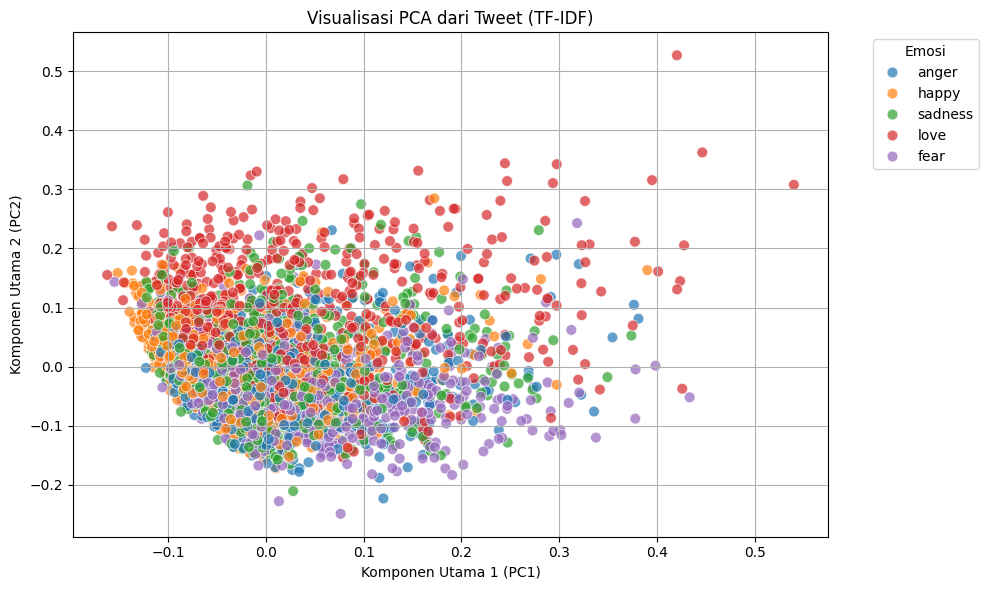

In [ ]:
# Deteksi jumlah data di setiap label
label_counts = Counter(labels)
print("\nJumlah data per label:")
for label, count in label_counts.items():
    print(f"{label}: {count} data")

# 1. TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
tfidf_matrix = vectorizer.fit_transform(texts)

# 2. PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(tfidf_matrix.toarray())

# 3. Create DataFrame for visualization
df_vis = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_vis['Label'] = labels

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='Label', palette='tab10', s=60, alpha=0.7)
plt.title('Visualisasi PCA dari Tweet (TF-IDF)')
plt.xlabel('Komponen Utama 1 (PC1)')
plt.ylabel('Komponen Utama 2 (PC2)')
plt.legend(title='Emosi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Split 80% train dan 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    texts, labels, test_size=0.20, random_state=42, stratify=labels
)

# Step 2: Dari 80% train, ambil 20% sebagai validation (hasilnya 16% dari total data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

# Cek jumlah data per subset
print(f"\nJumlah data:")
print(f"Train: {len(X_train)}")       # Harus sekitar 64% dari total
print(f"Validation: {len(X_val)}")   # Harus sekitar 16% dari total
print(f"Test: {len(X_test)}")        # Harus 20% dari total



Jumlah data:
Train: 2816
Validation: 704
Test: 881


In [ ]:
# Encode label ke angka
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Load Word2Vec
def load_word2vec(path):
    word2vec = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            word2vec[word] = vector
    return word2vec

word2vec = load_word2vec("/content/drive/MyDrive/Machine Learning/Word2Vec_400dim.txt")
EMBEDDING_DIM = 400

# Fungsi embedding rata-rata
def get_avg_embedding(text, model, dim=400):
    words = text.split()
    vectors = [model[w] for w in words if w in model]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

# Encode label
y_train_enc = le.transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Embedding untuk semua subset
X_train_embed_all = np.array([get_avg_embedding(t, word2vec, EMBEDDING_DIM) for t in X_train])
X_val_embed = np.array([get_avg_embedding(t, word2vec, EMBEDDING_DIM) for t in X_val])
X_test_embed = np.array([get_avg_embedding(t, word2vec, EMBEDDING_DIM) for t in X_test])

# Filter out training data yang hasil embedding-nya kosong
nonzero_idx = np.where(~np.all(X_train_embed_all == 0, axis=1))[0]
X_train_embed = X_train_embed_all[nonzero_idx]
y_train_enc = y_train_enc[nonzero_idx]

# Latih model Logistic Regression
w2v_model = LogisticRegression(max_iter=1000)
w2v_model.fit(X_train_embed, y_train_enc)

# Prediksi semua data
train_pred = w2v_model.predict(X_train_embed)
val_pred = w2v_model.predict(X_val_embed)
test_pred = w2v_model.predict(X_test_embed)

# Evaluasi akurasi
train_acc = accuracy_score(y_train_enc, train_pred)
val_acc = accuracy_score(y_val_enc, val_pred)
test_acc = accuracy_score(y_test_enc, test_pred)

print(f"\n[Logistic Regression + Word2Vec 400d]")
print(f"Akurasi Train     : {train_acc:.4f}")
print(f"Akurasi Validasi  : {val_acc:.4f}")
print(f"Akurasi Test      : {test_acc:.4f}")

# Laporan klasifikasi
print("\nLaporan Klasifikasi (Train Set):")
print(classification_report(y_train_enc, train_pred, target_names=le.classes_))

print("\nLaporan Klasifikasi (Validation Set):")
print(classification_report(y_val_enc, val_pred, target_names=le.classes_))

print("\nLaporan Klasifikasi (Test Set):")
print(classification_report(y_test_enc, test_pred, target_names=le.classes_))


[Logistic Regression + Word2Vec 400d]
Akurasi Train     : 0.7362
Akurasi Validasi  : 0.6122
Akurasi Test      : 0.5868

Laporan Klasifikasi (Train Set):
              precision    recall  f1-score   support

       anger       0.72      0.81      0.76       705
        fear       0.80      0.68      0.73       415
       happy       0.74      0.74      0.74       650
        love       0.85      0.82      0.83       408
     sadness       0.65      0.63      0.64       638

    accuracy                           0.74      2816
   macro avg       0.75      0.74      0.74      2816
weighted avg       0.74      0.74      0.74      2816


Laporan Klasifikasi (Validation Set):
              precision    recall  f1-score   support

       anger       0.66      0.75      0.70       176
        fear       0.58      0.54      0.56       104
       happy       0.64      0.64      0.64       163
        love       0.73      0.71      0.72       102
     sadness       0.46      0.42      0.44    

In [ ]:
# ===== 1. Persiapan Data =====

# Melakukan Label Encoding pada label (kategori kelas) ke bentuk angka
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # Fit + transform untuk data training
y_val_enc = le.transform(y_val)           # Transform untuk data validasi
y_test_enc = le.transform(y_test)         # Transform untuk data pengujian

# Load tokenizer IndoBERT dari HuggingFace
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Maksimum panjang input BERT (panjang maksimal tweet)
MAX_LEN = 256

# ===== 2. Dataset Kustom (untuk digunakan oleh DataLoader PyTorch) =====

class IndoBertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()         # Data input (teks)
        self.labels = labels                # Label numerik
        self.tokenizer = tokenizer          # Tokenizer IndoBERT
        self.max_len = max_len              # Panjang maksimum token

    def __len__(self):
        return len(self.texts)              # Panjang dataset

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenisasi dan encoding teks
        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'  # Hasil dikembalikan dalam format tensor PyTorch
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),           # Tensor input ID
            'attention_mask': encoded['attention_mask'].squeeze(0), # Tensor attention mask
            'label': torch.tensor(label, dtype=torch.long)          # Tensor label
        }

# Membuat objek dataset dan dataloader untuk train/val/test
train_dataset = IndoBertDataset(X_train, y_train_enc, tokenizer, MAX_LEN)
val_dataset = IndoBertDataset(X_val, y_val_enc, tokenizer, MAX_LEN)
test_dataset = IndoBertDataset(X_test, y_test_enc, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# ===== 3. Model: IndoBERT + Classifier =====

class IndoBertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(IndoBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("indobenchmark/indobert-base-p1")  # Load IndoBERT
        self.dropout = nn.Dropout(0.3)                    # Dropout layer (untuk regularisasi)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)  # Fully-connected output layer

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.pooler_output                        # Ambil hasil pooling dari BERT
        return self.classifier(self.dropout(pooled))         # Hasil akhir prediksi kelas

# Inisialisasi model dan perangkat (CPU / GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IndoBertClassifier(num_labels=len(le.classes_)).to(device)

# ===== 4. Training Loop =====

# Optimizer dan fungsi loss
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()  # Cocok untuk klasifikasi multi-kelas

# Fungsi untuk melatih model selama 1 epoch
def train_epoch(model, loader):
    model.train()
    total_loss, total_correct = 0, 0

    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)                    # Prediksi label
        total_correct += torch.sum(preds == labels).item()      # Hitung prediksi yang benar

        loss.backward()      # Backpropagation
        optimizer.step()     # Update bobot
        optimizer.zero_grad()# Reset gradien

    acc = total_correct / len(loader.dataset)
    return total_loss / len(loader), acc

# Fungsi untuk evaluasi (tanpa training)
def eval_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():  # Tidak menyimpan gradien (lebih efisien)
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=le.classes_)
    return acc, report


# ===== 5. Latih & Evaluasi =====

for epoch in range(10):
    print(f"\nEpoch {epoch + 1}")
    train_loss, train_acc = train_epoch(model, train_loader)
    val_acc, val_report = eval_model(model, val_loader)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Acc   : {val_acc:.4f}")

# ===== 6. Evaluasi Akhir & Laporan =====

# Evaluasi akhir untuk semua set (train, val, test)
train_acc, train_report = eval_model(model, train_loader)
val_acc, val_report = eval_model(model, val_loader)
test_acc, test_report = eval_model(model, test_loader)

print("\n[IndoBERT Final Evaluation]")
print(f"Akurasi Train     : {train_acc:.4f}")
print(f"Akurasi Validasi  : {val_acc:.4f}")
print(f"Akurasi Test      : {test_acc:.4f}")

print("\nLaporan Klasifikasi (Train Set):")
print(train_report)

print("\nLaporan Klasifikasi (Validation Set):")
print(val_report)

print("\nLaporan Klasifikasi (Test Set):")
print(test_report)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Epoch 1


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 1.0086 | Train Acc: 0.5913
Val Acc   : 0.7173

Epoch 2


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.5487 | Train Acc: 0.8171
Val Acc   : 0.6847

Epoch 3


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.2568 | Train Acc: 0.9130
Val Acc   : 0.6989

Epoch 4


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.0902 | Train Acc: 0.9766
Val Acc   : 0.6847

Epoch 5


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.0743 | Train Acc: 0.9773
Val Acc   : 0.6875

Epoch 6


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.0533 | Train Acc: 0.9872
Val Acc   : 0.6974

Epoch 7


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.0339 | Train Acc: 0.9915
Val Acc   : 0.7045

Epoch 8


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.0476 | Train Acc: 0.9837
Val Acc   : 0.6960

Epoch 9


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.0505 | Train Acc: 0.9822
Val Acc   : 0.7116

Epoch 10


  0%|          | 0/176 [00:00<?, ?it/s]

Train Loss: 0.0258 | Train Acc: 0.9922
Val Acc   : 0.7173

[IndoBERT Final Evaluation]
Akurasi Train     : 0.9975
Akurasi Validasi  : 0.7173
Akurasi Test      : 0.7060

Laporan Klasifikasi (Train Set):
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       705
        fear       1.00      1.00      1.00       415
       happy       1.00      1.00      1.00       650
        love       0.99      1.00      0.99       408
     sadness       1.00      1.00      1.00       638

    accuracy                           1.00      2816
   macro avg       1.00      1.00      1.00      2816
weighted avg       1.00      1.00      1.00      2816


Laporan Klasifikasi (Validation Set):
              precision    recall  f1-score   support

       anger       0.76      0.77      0.77       176
        fear       0.79      0.73      0.76       104
       happy       0.85      0.57      0.68       163
        love       0.72      0.87      0.79       102